<a href="https://colab.research.google.com/github/tcn1john/Alpha_Blackbox/blob/main/TWII_next_day_alpha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Financial black box : Share insights without exposing the logic
#####  This is an example of gathering data of Nasdaq-100 (^NDX) from yahoo finance, and making an alpha for trading at/around market close. The Alpha is calculated in Google Cloud Function and its logic is protected. If the usage of the alpha is to be against the creator's interest, it can be shut-down anytime without leaking future info.

In [ ]:
import numpy as np
import yfinance as yf
import time as time
import datetime as datetime
import pandas as pd

def getprice_yf(tickername, period_default, interval):
  nowstock_yf = yf.Ticker(tickername)
  yfprice = nowstock_yf.history(period=period_default,interval=interval)
  print('Asked yfinance for '+tickername+' data, rows = ' + str(len(yfprice)))
  time.sleep(0.4)
  return yfprice

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


### Get data from yahoo finance.

In [ ]:
df = getprice_yf('^NDX', '500d', '1d')
df['returns'] = df.Close.pct_change()

Asked yfinance for ^NDX data, rows = 500


In [ ]:
df.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns
Date,,,,,,,,
2024-02-16 00:00:00-05:00,17853.589844,17864.160156,17663.400391,17685.980469,5223800000,0.0,0.0,-0.008951
2024-02-20 00:00:00-05:00,17591.169922,17657.080078,17399.410156,17546.099609,5595700000,0.0,0.0,-0.007909
2024-02-21 00:00:00-05:00,17412.789062,17482.130859,17319.439453,17478.910156,4845740000,0.0,0.0,-0.003829
2024-02-22 00:00:00-05:00,17857.759766,18034.800781,17808.259766,18004.699219,5653930000,0.0,0.0,0.030081
2024-02-23 00:00:00-05:00,18052.589844,18091.619141,17902.779297,17937.609375,5077910000,0.0,0.0,-0.003726


#### Now, the cloud function return the tailored alpha from me, calculated from the input data of the user!


In [ ]:
def get_ndx_alp_from_kbars_df(df):
    import requests
    url = 'https://asia-east1-grounded-access-387509.cloudfunctions.net/AlphaReturn'  # Replace this with your API endpoint
    headers = {'Content-Type': 'application/json'}
    try:
        response = requests.post(url, data=df.to_json(orient='records'), headers=headers)
        if response.status_code == 200:
            return response.text
        else:
            print("Failed to send data. Status code:", response.status_code)
    except requests.exceptions.RequestException as e:
        print("Error:", e)

cloud_alp = get_ndx_alp_from_kbars_df(df)
alpdf = pd.read_json(cloud_alp)
alpdf.iloc[:100,:2] = np.nan
alpdf.index = df.index
alpdf.to_csv('historical_alpha_validation_since_202402.csv')
alpdf

,NDX_trade_at_market_close,NDX_position_since_last_close,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns
Date,,,,,,,,,,
2022-02-28 00:00:00-05:00,NaN,NaN,14058.610352,14296.599609,14009.360352,14237.809570,5928130000,0,0,NaN
2022-03-01 00:00:00-05:00,NaN,NaN,14197.660156,14271.580078,13906.919922,14005.990234,6131350000,0,0,-0.016282
2022-03-02 00:00:00-05:00,NaN,NaN,14075.110352,14292.719727,13962.690430,14243.690430,5246390000,0,0,0.016971
2022-03-03 00:00:00-05:00,NaN,NaN,14339.700195,14342.559570,13965.110352,14035.209961,5092580000,0,0,-0.014637
2022-03-04 00:00:00-05:00,NaN,NaN,13957.599609,13992.969727,13738.610352,13837.830078,5343900000,0,0,-0.014063
...,...,...,...,...,...,...,...,...,...,...
2024-02-16 00:00:00-05:00,-1.0,-1.0,17853.589844,17864.160156,17663.400391,17685.980469,5223800000,0,0,-0.008951
2024-02-20 00:00:00-05:00,0.0,-1.0,17591.169922,17657.080078,17399.410156,17546.099609,5595700000,0,0,-0.007909
2024-02-21 00:00:00-05:00,1.0,0.0,17412.789062,17482.130859,17319.439453,17478.910156,4845740000,0,0,-0.003829


##### How to use it? 'NDX_position_since_last_close' is for backtesting this alpha, and 'NDX_trade_at_market_close' is the position you aim to have after the latest data is sent to cloud function. It should be traded asap after the data is acquired. The relation of the two is shift(1).

##### (The alpha needs 100 days or so at the start. Don't use it until 100~150+ days!)


Text(0.5, 0, 'Date')

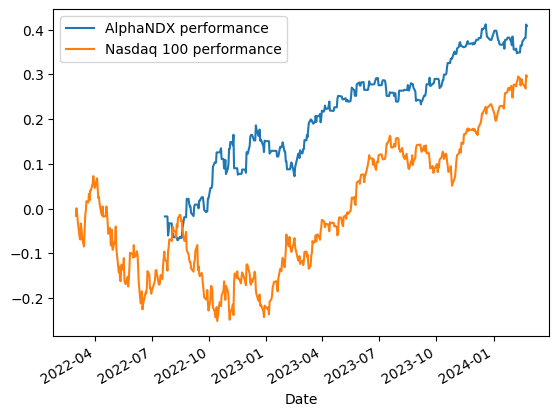

In [ ]:
import matplotlib.pyplot as plt
fig = ( alpdf['NDX_position_since_last_close'] * (alpdf.returns) ).cumsum().plot(label = 'AlphaNDX performance')
plt.plot( ((1) * alpdf.returns).cumsum() , label = 'Nasdaq 100 performance')
plt.legend()
plt.xlabel('Date')

#### Future-Peeking Validation:
> Write down the latest alpha prediction, and compare it with addtional next-day info sent to the function.


#### Benefits:
#### 1. Logic of alpha is protected, and can be share with others!
#### 2. User can validate through challenging the function with custom data.

> ex. Checking Cloud_function( NDX(days=['20210101', '20220202']) )


#### 3. Long-Short neutral alpha of NDX index, which can be traded as future with low fee.